# Quantum Neural Network (QNN) with Qutrits for Moons Dataset

In this Jupyter notebook, I present the implementation of a Quantum Neural Network (QNN) using qutrits to tackle the moons dataset. The moons dataset is a binary classification problem containing two interleaving half-moon shapes, posing a challenge for linear classifiers.

In [1]:
import numpy as np
from scipy.linalg import expm
import pandas as pd
import warnings
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn import neighbors
from matplotlib.ticker import MaxNLocator # needed for integer only on axis
from matplotlib.lines import Line2D # for creating the custom legend
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
plt.style.use('ipynb')

### Moons Dataset

The moons dataset consists of two half-moon shapes that are intertwined, making it difficult for linear classifiers to achieve accurate predictions.

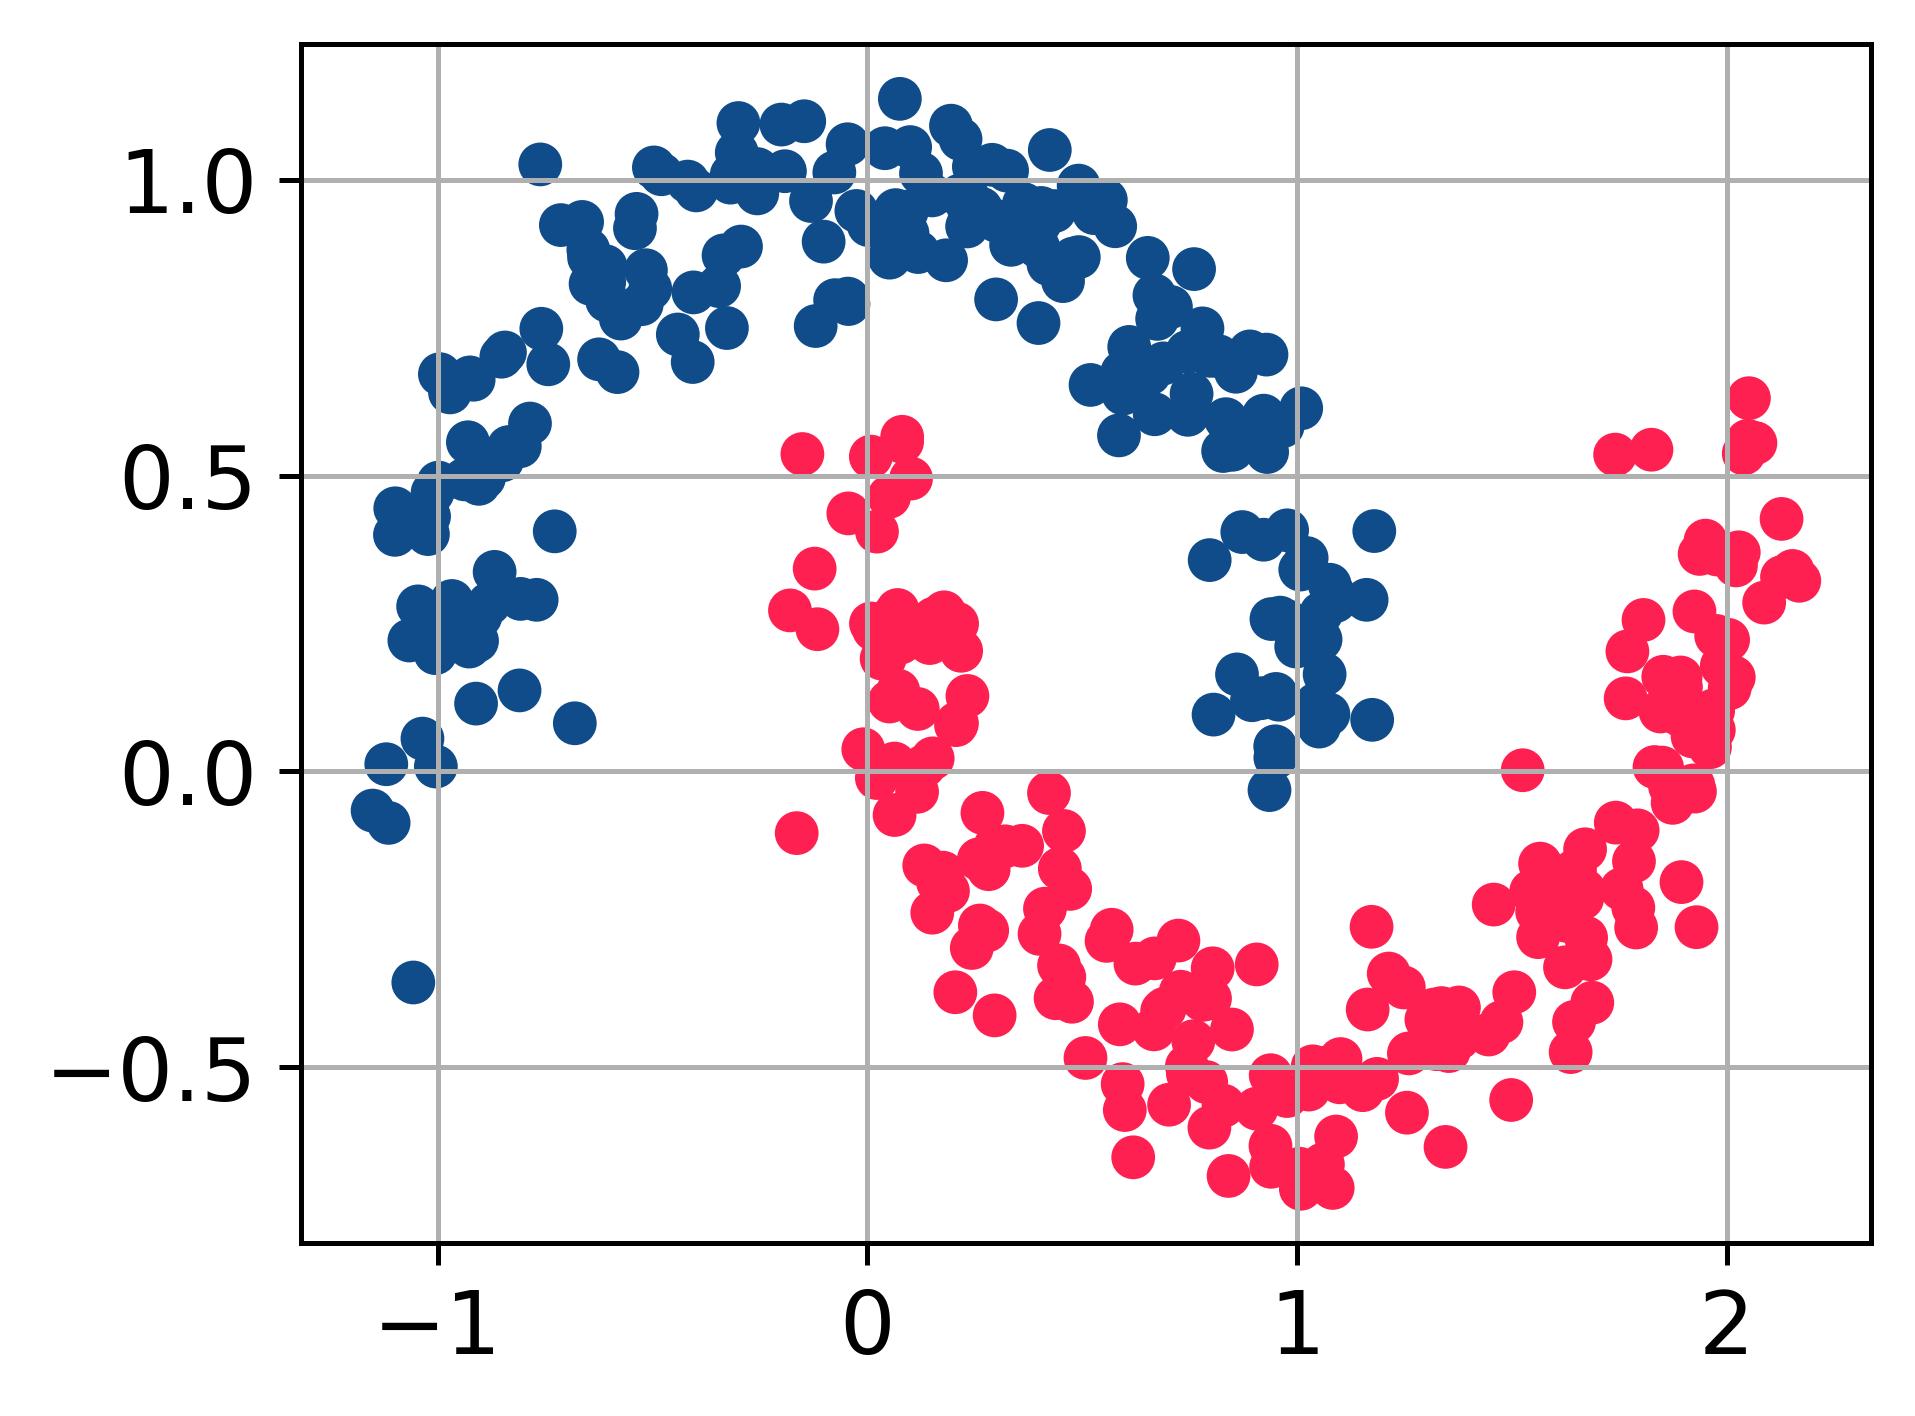

In [2]:
# Create a color map for the two classes
label1_colour = '#104c89'
label2_colour = '#ff2052'
color_map = ListedColormap([label1_colour, label2_colour])

# Generate moons dataset
X, y = make_moons(n_samples=400, noise=0.1, random_state=42)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=color_map)
plt.grid(True)
plt.show()

In [4]:
# scaling the inputs is important since the embedding we use is periodic
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)
y_scaled = np.eye(3)[y]

print('Shape of X:', X_scaled.shape)
print('Shape of y:', y_scaled.shape)
print('x[0] feature example: ', X_scaled[0])
print('y[0]: ', y_scaled[198])


Shape of X: (400, 2)
Shape of y: (400, 3)
x[0] feature example:  [-0.63112161  0.36108719]
y[0]:  [0. 1. 0.]


In [5]:
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]


X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, stratify=y_scaled, random_state=42)

# Use np.sum to count the number of instances of each class in both sets
print("Class counts in training set:", np.sum(y_train, axis=0))
print("Class counts in test set:", np.sum(y_test, axis=0))

# Create PyTorch datasets and dataloaders
train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False)


Class counts in training set: [160. 160.   0.]
Class counts in test set: [40. 40.  0.]


We'll design a quantum circuit that forms the core of our QNN. The circuit will comprise layers of qutrit-based quantum gates, allowing for more expressive quantum representations of the input data. This will be followed by the classical optimizer that updates the parameters based on the output and the ground truth labels.

The Quantum Neural Network (QNN) class employs qutrit states, Gell-Mann matrices, and parameterized rotations to process the input data. The network is composed of multiple layers, each containing weights for Gell-Mann rotations and a bias term. During the forward pass, the QNN applies encoding and variational rotations using the weights and Gell-Mann matrices to manipulate the qutrit states.

In [6]:
class QNN(nn.Module):
    
    def __init__(self, num_layers, num_features):
        super(QNN, self).__init__()

        self.num_layers = num_layers
        self.num_features = num_features
        
        # Define the qutrit states as column vectors
        self.q0 = torch.tensor([[1], [0], [0]], dtype=torch.cfloat)
        self.q1 = torch.tensor([[0], [1], [0]], dtype=torch.cfloat)
        self.q2 = torch.tensor([[0], [0], [1]], dtype=torch.cfloat)

        # Define the Gell-Mann matrices
        self.gm1 = torch.kron(self.q0, self.q1.T) + torch.kron(self.q1, self.q0.T)
        self.gm2 = -1j * (torch.kron(self.q0, self.q1.T) - torch.kron(self.q1, self.q0.T))
        self.gm3 = torch.kron(self.q0, self.q0.T) - torch.kron(self.q1, self.q1.T)
        self.gm4 = torch.kron(self.q0, self.q2.T) + torch.kron(self.q2, self.q0.T)
        self.gm5 = -1j * (torch.kron(self.q0, self.q2.T) - torch.kron(self.q2, self.q0.T))
        self.gm6 = torch.kron(self.q1, self.q2.T) + torch.kron(self.q2, self.q1.T)
        self.gm7 = -1j * (torch.kron(self.q1, self.q2.T) - torch.kron(self.q2, self.q1.T))
        self.gm8 = 1/torch.sqrt(torch.tensor(3., dtype=torch.float)) * (torch.kron(self.q0, self.q0.T) + torch.kron(self.q1, self.q1.T) - 2*torch.kron(self.q2, self.q2.T))
        self.lz = self.gm3 + torch.sqrt(torch.tensor(3., dtype=torch.float)) * self.gm8
        self.lz[1][1]=0
        self.hadamard = (1 / torch.sqrt(torch.tensor(3.0))) * torch.tensor([[1, 1, 1], [1, torch.exp(torch.tensor(2j) * torch.tensor(3.1416 / 3.0)) , torch.exp(torch.tensor(-2j) * torch.tensor(3.1416 / 3.0))], [1, torch.exp(torch.tensor(-2j) * torch.tensor(3.1416 / 3.0)), torch.exp(torch.tensor(2j) * torch.tensor(3.1416 / 3.0))]], dtype=torch.cfloat)
        self.LZZ2 = torch.kron(self.lz, self.lz)

        # Collect the Gell-Mann matrices in a list
        self.generators = [self.gm1, self.gm2, self.gm3, self.gm4, self.gm5, self.gm6, self.gm7, self.gm8]

        # Define the weights
        self.weights = nn.ParameterList()
        self.bias = nn.ParameterList()

        for i in range(self.num_layers):
            
            # Weights for the Gell-Mann rotations
            self.weights.append(nn.Parameter(torch.randn(4, dtype=torch.float)))

            # Weight for the bias term
            self.bias.append(nn.Parameter(torch.randn(1, dtype=torch.float)))

    def forward(self, batch):
        
        logits = torch.empty(batch.shape[0], 3, dtype=torch.double)

        for idx, x in enumerate(batch):

            qutrit_1 = self.q0

            # Apply parameterized rotations using Gell-Mann matrices and Rot(w) weights
            for i in range(self.num_layers):
                
                # Apply the encoding with the Gell-Mann matrices
                gm_weights = self.weights[i]
                
                # The first 4 Features in the first qutrit
                encoded = torch.zeros([3,3], dtype=torch.cfloat)
                for index in range(4):
                    encoded += (1j * x[(index+4*i)%2] * self.generators[index+4])
                qutrit_1 = torch.matmul(torch.matrix_exp(encoded), qutrit_1)

                # The first variational for first qutrit
                encoded = torch.zeros([3,3], dtype=torch.cfloat)
                for index in range(4):
                    encoded += (1j * gm_weights[index] * self.generators[index])

                # Add bias term with the identity matrix
                encoded += 1j * self.bias[i][0] * torch.eye(3)
                qutrit_1 = torch.matmul(torch.matrix_exp(encoded), qutrit_1)

            # state = torch.kron(qutrit_1, qutrit_2)
            probabilities = torch.abs(qutrit_1.flatten())**2
    
            # Normalize the probabilities   
            probabilities /= torch.sum(probabilities)
            logits[idx] = probabilities

        return logits


### Decision Boundary Function

In [17]:
def plot_decision_boundary2D(model, X: np.ndarray, y: np.ndarray, classes: list, colormap: np.ndarray,
                             step: float = 0.1, prob_dot_scale: int = 40, prob_dot_scale_power: int = 3,
                             true_dot_size: int = 50, pad: float = 1.0,
                             prob_values: list = [0.4, 0.6, 0.8, 1.0]) -> None:
    """
    Original work by @timothyvh on Twitter.
    Recreating an R ggplot decision boundary plotting in python using matplotlib. 
    Note that this only works for 2D plotting. The goal of this function is to present a 
    classifier's decision boundary in an easy to read, digestible way to ease
    communication and visualization of results. 
    
    Arguments:
    clf - the classifier we want to visualize the decision boundary for. This should work for any kind of relevant model.
    X - our data we want to plot. Note that since this is a 2D array, X should be 2-dimensional.
    y - the target labels for the data we want to plot
    classes - the names of the classes you are trying to identify, should be same shape as colormap
    colormap - the colors you want to use to indicate your different classes, should be same shape as classes
    step - mesh stepsize
    prob_dot_scale - modifier to scale the probability dots
    prob_dot_scale_power - exponential used to increase/decrease size of prob dots
    true_dot_size - size of the true labels
    pad - how much to "pad" around the true labels
    prob_values - list of probabilities to map the meshgrid predictions to

    Returns:
    None - This function will simply output a graph of the decision boundary
    """
    # Handling X data dimension issues. If X doesn't have enough dimensions, throw error. Too many, use first two dimensions.
    X_dim = X.shape[1]
    if X_dim < 2:
        raise Exception("Error: Not enough dimensions in input data. Data must be at least 2-dimensional.")
    elif X_dim > 2: 
        warnings.warn(f"Warning: input data was {X_dim} dimensional. Expected 2. Using first 2 dimensions provided.")
    
    # Change colormap to a numpy array if it isn't already (necessary to prevent scalar error)
    if not isinstance(colormap, np.ndarray):
        colormap = np.array(colormap)        
        
    # create the x0, x1 feature. This is only a 2D plot after all. 
    x0 = X[:,0]
    x1 = X[:,1]
    
    # create 1D arrays representing the range of probability data points
    x0_min, x0_max = np.round(x0.min())-pad, np.round(x0.max()+pad)
    x1_min, x1_max = np.round(x1.min())-pad, np.round(x1.max()+pad)    
    x0_axis_range = np.arange(x0_min,x0_max, step)
    x1_axis_range = np.arange(x1_min,x1_max, step)
    
    # create meshgrid between the two axis ranges
    xx0, xx1 = np.meshgrid(x0_axis_range, x1_axis_range)
    
    # put the xx in the same dimensional format as the original X
    xx = np.reshape(np.stack((xx0.ravel(),xx1.ravel()),axis=1),(-1,2))
    output = model(xx)
    yy_hat = torch.argmax(output, dim=1)
    yy_size = torch.max(output, dim=1)[0].detach().numpy()
    
    # make figure
    plt.style.use('seaborn-v0_8') # set style because it looks nice
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6), dpi=150)
    
    # plot all the little dots
    ax.scatter(xx[:,0], xx[:,1], c=colormap[yy_hat], alpha=0.4, s=prob_dot_scale*yy_size**prob_dot_scale_power, linewidths=0,)
    
    # plot the contours
    ax.contour(x0_axis_range, x1_axis_range, 
               np.reshape(yy_hat,(xx0.shape[0],-1)), 
               levels=3, linewidths=1, 
               colors=[colormap[0],colormap[1], colormap[1], colormap[2],])
 
    # plot the original x values.
    ax.scatter(x0, x1, c=colormap[y], s=true_dot_size, zorder=3, linewidths=0.7, edgecolor='k')
 
    # create legends - Not sure if these serve a purpose but I left them in just in case
    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()
 
    ax.set_ylabel(r"$x_1$")
    ax.set_xlabel(r"$x_0$")
    
    # set the aspect ratio to 1, for looks
    ax.set_aspect(1)
 
    # create class legend
    legend_class = []
    for class_id, color in zip(classes, colormap):
        legend_class.append(Line2D([0], [0], marker='o', label=class_id,ls='None',
                                   markerfacecolor=color, markersize=np.sqrt(true_dot_size), 
                                   markeredgecolor='k', markeredgewidth=0.7))
 
    # iterate over each of the probabilities to create prob legend
    legend_prob = []
    for prob in prob_values:
        legend_prob.append(Line2D([0], [0], marker='o', label=prob, ls='None', alpha=0.8,
                                  markerfacecolor='grey', 
                                  markersize=np.sqrt(prob_dot_scale*prob**prob_dot_scale_power), 
                                  markeredgecolor='k', markeredgewidth=0))
 
 
    legend1 = ax.legend(handles=legend_class, loc='center', 
                        bbox_to_anchor=(1.05, 0.35),
                        frameon=False, title='class')
 
    legend2 = ax.legend(handles=legend_prob, loc='center', 
                        bbox_to_anchor=(1.05, 0.65),
                        frameon=False, title='prob', )
 
    ax.add_artist(legend1) # add legend back after it disappears
 
    ax.set_yticks(np.arange(x1_min,x1_max, 1)) # I don't like the decimals
    ax.grid(False) # remove gridlines (inherited from 'seaborn-whitegrid' style)
 
    # only use integers for axis tick labels
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
 
    # remove first ticks from axis labels, for looks
    ax.set_xticks(ax.get_xticks()[1:-1])
    ax.set_yticks(np.arange(x1_min,x1_max, 1)[1:])
 
    plt.show()

### Training

In this code section, we implement the training process for a Quantum Neural Network (QNN) with qutrits to address a binary classification problem. The QNN is constructed with a specified number of layers (LAYERS) and the number of features in the input data (num_features). To facilitate stable training and avoid large parameter updates, we apply constraints to the parameter ranges of the QNN model. 

The training process utilizes the RMSprop optimizer with a learning rate of 8e-3 and the CrossEntropyLoss function as the loss metric. To find a good initial point in the landscape we continue the training loop until the desired minimum threshold is achieved. This iterative approach ensures effective training of the Quantum Neural Network with qutrits.

In [11]:
EPOCHS = 0
LAYERS = 3

acura = 0
while(acura<90):

    model = QNN(num_layers=LAYERS, num_features=X_train.shape[1])

    # Apply constraints to parameter ranges
    threshold = 0.9

    for param in model.parameters():
        param.data.clamp_(-threshold, threshold)

    optimizer = torch.optim.RMSprop(model.parameters(), lr=8e-3)
    loss_func = nn.CrossEntropyLoss()

    # Set the model to training mode
    model.train()

    for batch_idx, (data, target) in enumerate(train_dataloader):

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(data)

        loss = loss_func(output, target)

        # Backward pass
        loss.backward()

        # Update the weights
        optimizer.step()

    correct = 0
    total = 0   

    # Evaluate the model on the test data and print the accuracy
    with torch.no_grad():
        
        for batch_idx, (data, target) in enumerate(test_dataloader):
            output = model(data)

            predicted_labels = torch.argmax(output, dim=1)

            # Find the ground truth labels by taking the argmax along the appropriate axis
            ground_truth_labels = torch.argmax(target, dim=1)

            correct += (predicted_labels == ground_truth_labels).sum().item()

    acura = correct / len(test_dataloader)/4*100
    print(acura)
    clear_output(True)

# Iterate over the training data for a fixed number of epochs
for epoch in range(EPOCHS):

    for batch_idx, (data, target) in enumerate(train_dataloader):

        # Zero the gradients
        optimizer.zero_grad()

         # Forward pass
        output = model(data)

        loss = loss_func(output, target)

        # Backward pass
        loss.backward()

        # Update the weights
        optimizer.step()

    correct = 0
    total = 0   

    # Evaluate the model on the test data and print the accuracy
    with torch.no_grad():
        
        for batch_idx, (data, target) in enumerate(test_dataloader):
            output = model(data)

            predicted_labels = torch.argmax(output, dim=1)

            # Find the ground truth labels by taking the argmax along the appropriate axis
            ground_truth_labels = torch.argmax(target, dim=1)

            correct += (predicted_labels == ground_truth_labels).sum().item()

    acura = correct / len(test_dataloader)/4*100

    print("Epoch {}:\n\tAccuracy: {:.1f}%".format(
        epoch+1, acura
    ))

91.25


[0.58077347 0.63373786 0.65680999 ... 0.84355801 0.81302267 0.77471536]


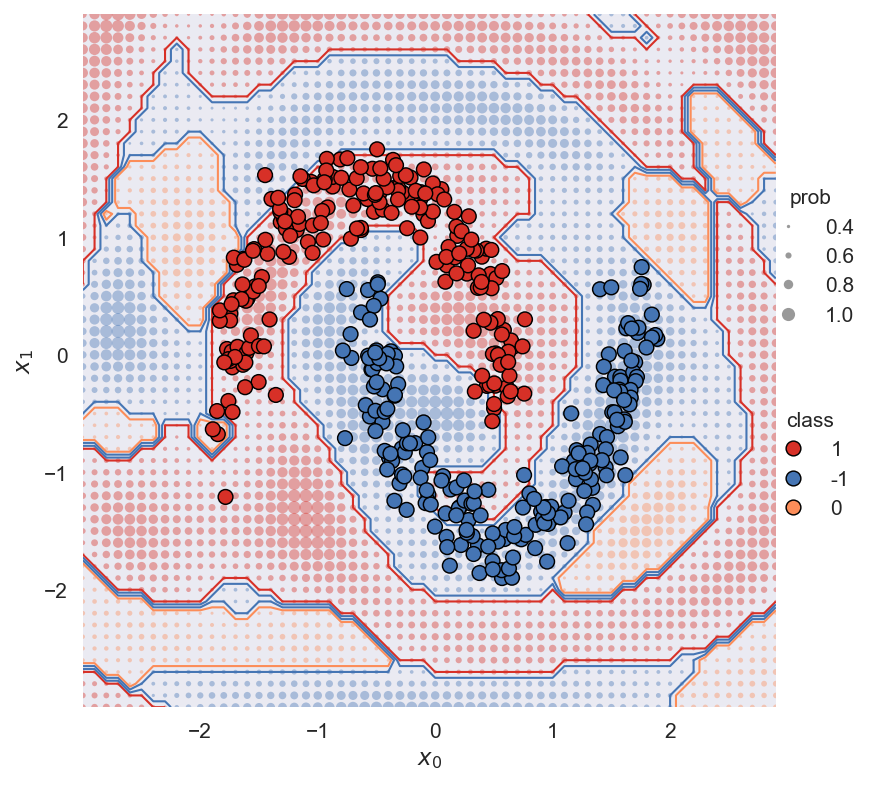

In [12]:
# Parameters for decision boundary plot
N_NEIGHBORS = 15
H = 0.1 
PROB_DOT_SCALE = 40
PROB_DOT_SCALE_POWER = 3
TRUE_DOT_SIZE = 50
PAD = 1.0

# Establish colors and colormap
redish = '#d73027'
orangeish = '#fc8d59'
blueish = '#4575b4'
colormap = np.array([redish,blueish, orangeish])

# Establish classes
classes = ['1','-1', '0']
x = X_scaled

# Use function
plot_decision_boundary2D(model, x, y.copy(), classes, colormap, 
                         step=H, 
                         prob_dot_scale=PROB_DOT_SCALE, 
                         prob_dot_scale_power=PROB_DOT_SCALE_POWER,
                         true_dot_size=TRUE_DOT_SIZE, 
                         pad=PAD,)

Then increasing the number of layers to 4 and training again.

In [20]:
EPOCHS = 0
LAYERS = 4

acura = 0
while(acura<94):

    model = QNN(num_layers=LAYERS, num_features=X_train.shape[1])

    # Apply constraints to parameter ranges
    threshold = 0.9

    for param in model.parameters():
        param.data.clamp_(-threshold, threshold)

    optimizer = torch.optim.RMSprop(model.parameters(), lr=8e-3)
    loss_func = nn.CrossEntropyLoss()

    # Set the model to training mode
    model.train()

    for batch_idx, (data, target) in enumerate(train_dataloader):

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(data)

        loss = loss_func(output, target)


        # Backward pass
        loss.backward()

        # Update the weights
        optimizer.step()

    correct = 0
    total = 0   

    # Evaluate the model on the test data and print the accuracy
    with torch.no_grad():
        
        for batch_idx, (data, target) in enumerate(test_dataloader):
            output = model(data)

            predicted_labels = torch.argmax(output, dim=1)

            # Find the ground truth labels by taking the argmax along the appropriate axis
            ground_truth_labels = torch.argmax(target, dim=1)

            correct += (predicted_labels == ground_truth_labels).sum().item()

    acura = correct / len(test_dataloader)/4*100
    print(acura)
    clear_output(True)

# Iterate over the training data for a fixed number of epochs
for epoch in range(EPOCHS):

    for batch_idx, (data, target) in enumerate(train_dataloader):

        # Zero the gradients
        optimizer.zero_grad()

         # Forward pass
        output = model(data)

        loss = loss_func(output, target)

        # Backward pass
        loss.backward()

        # Update the weights
        optimizer.step()

    correct = 0
    total = 0   

    # Evaluate the model on the test data and print the accuracy
    with torch.no_grad():
        
        for batch_idx, (data, target) in enumerate(test_dataloader):
            output = model(data)

            predicted_labels = torch.argmax(output, dim=1)

            # Find the ground truth labels by taking the argmax along the appropriate axis
            ground_truth_labels = torch.argmax(target, dim=1)

            correct += (predicted_labels == ground_truth_labels).sum().item()

    acura = correct / len(test_dataloader)/4*100

    print("Epoch {}:\n\tAccuracy: {:.1f}%".format(
        epoch+1, acura
    ))

100.0


After training, we'll visualize the classification results and decision boundaries.

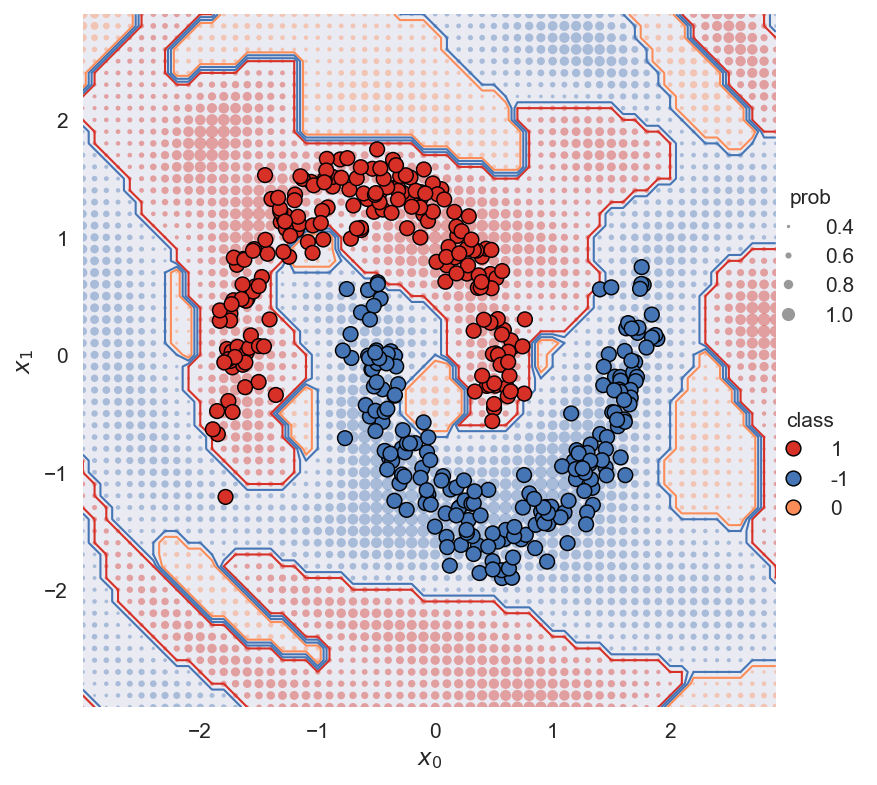

In [21]:
# Parameters for decision boundary plot
N_NEIGHBORS = 15
H = 0.1 
PROB_DOT_SCALE = 40
PROB_DOT_SCALE_POWER = 3
TRUE_DOT_SIZE = 50
PAD = 1.0

# Establish colors and colormap
redish = '#d73027'
orangeish = '#fc8d59'
blueish = '#4575b4'
colormap = np.array([redish,blueish, orangeish])

# Establish classes
classes = ['1','-1', '0']
x = X_scaled

# Use function
plot_decision_boundary2D(model, x, y.copy(), classes, colormap, 
                         step=H, 
                         prob_dot_scale=PROB_DOT_SCALE, 
                         prob_dot_scale_power=PROB_DOT_SCALE_POWER,
                         true_dot_size=TRUE_DOT_SIZE, 
                         pad=PAD,)